In [1]:
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
sns.set(style='ticks', context='notebook', palette='colorblind', font='serif')

import utils
plt.rcParams.update(utils.rcParams)

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde as Bounded_1d_kde
import corner

In [2]:
# A list of events
event_list = ["S150914", "S190519bj", "S190521r"]

# Color for each event
color_dict = {}
color_dict.update({
    "S190519bj": sns.color_palette("Set1", desat=0.7)[0],
    "S190521r": sns.color_palette("Set1", desat=0.7)[2],
    "S150914": sns.color_palette("Set1", desat=0.7)[1],
})

data_file_path_template = "{event}/rin_{event}_pyring_{param}.dat.gz"

# Parameters to be visualized
params = ["domega_221", "dtau_221"]

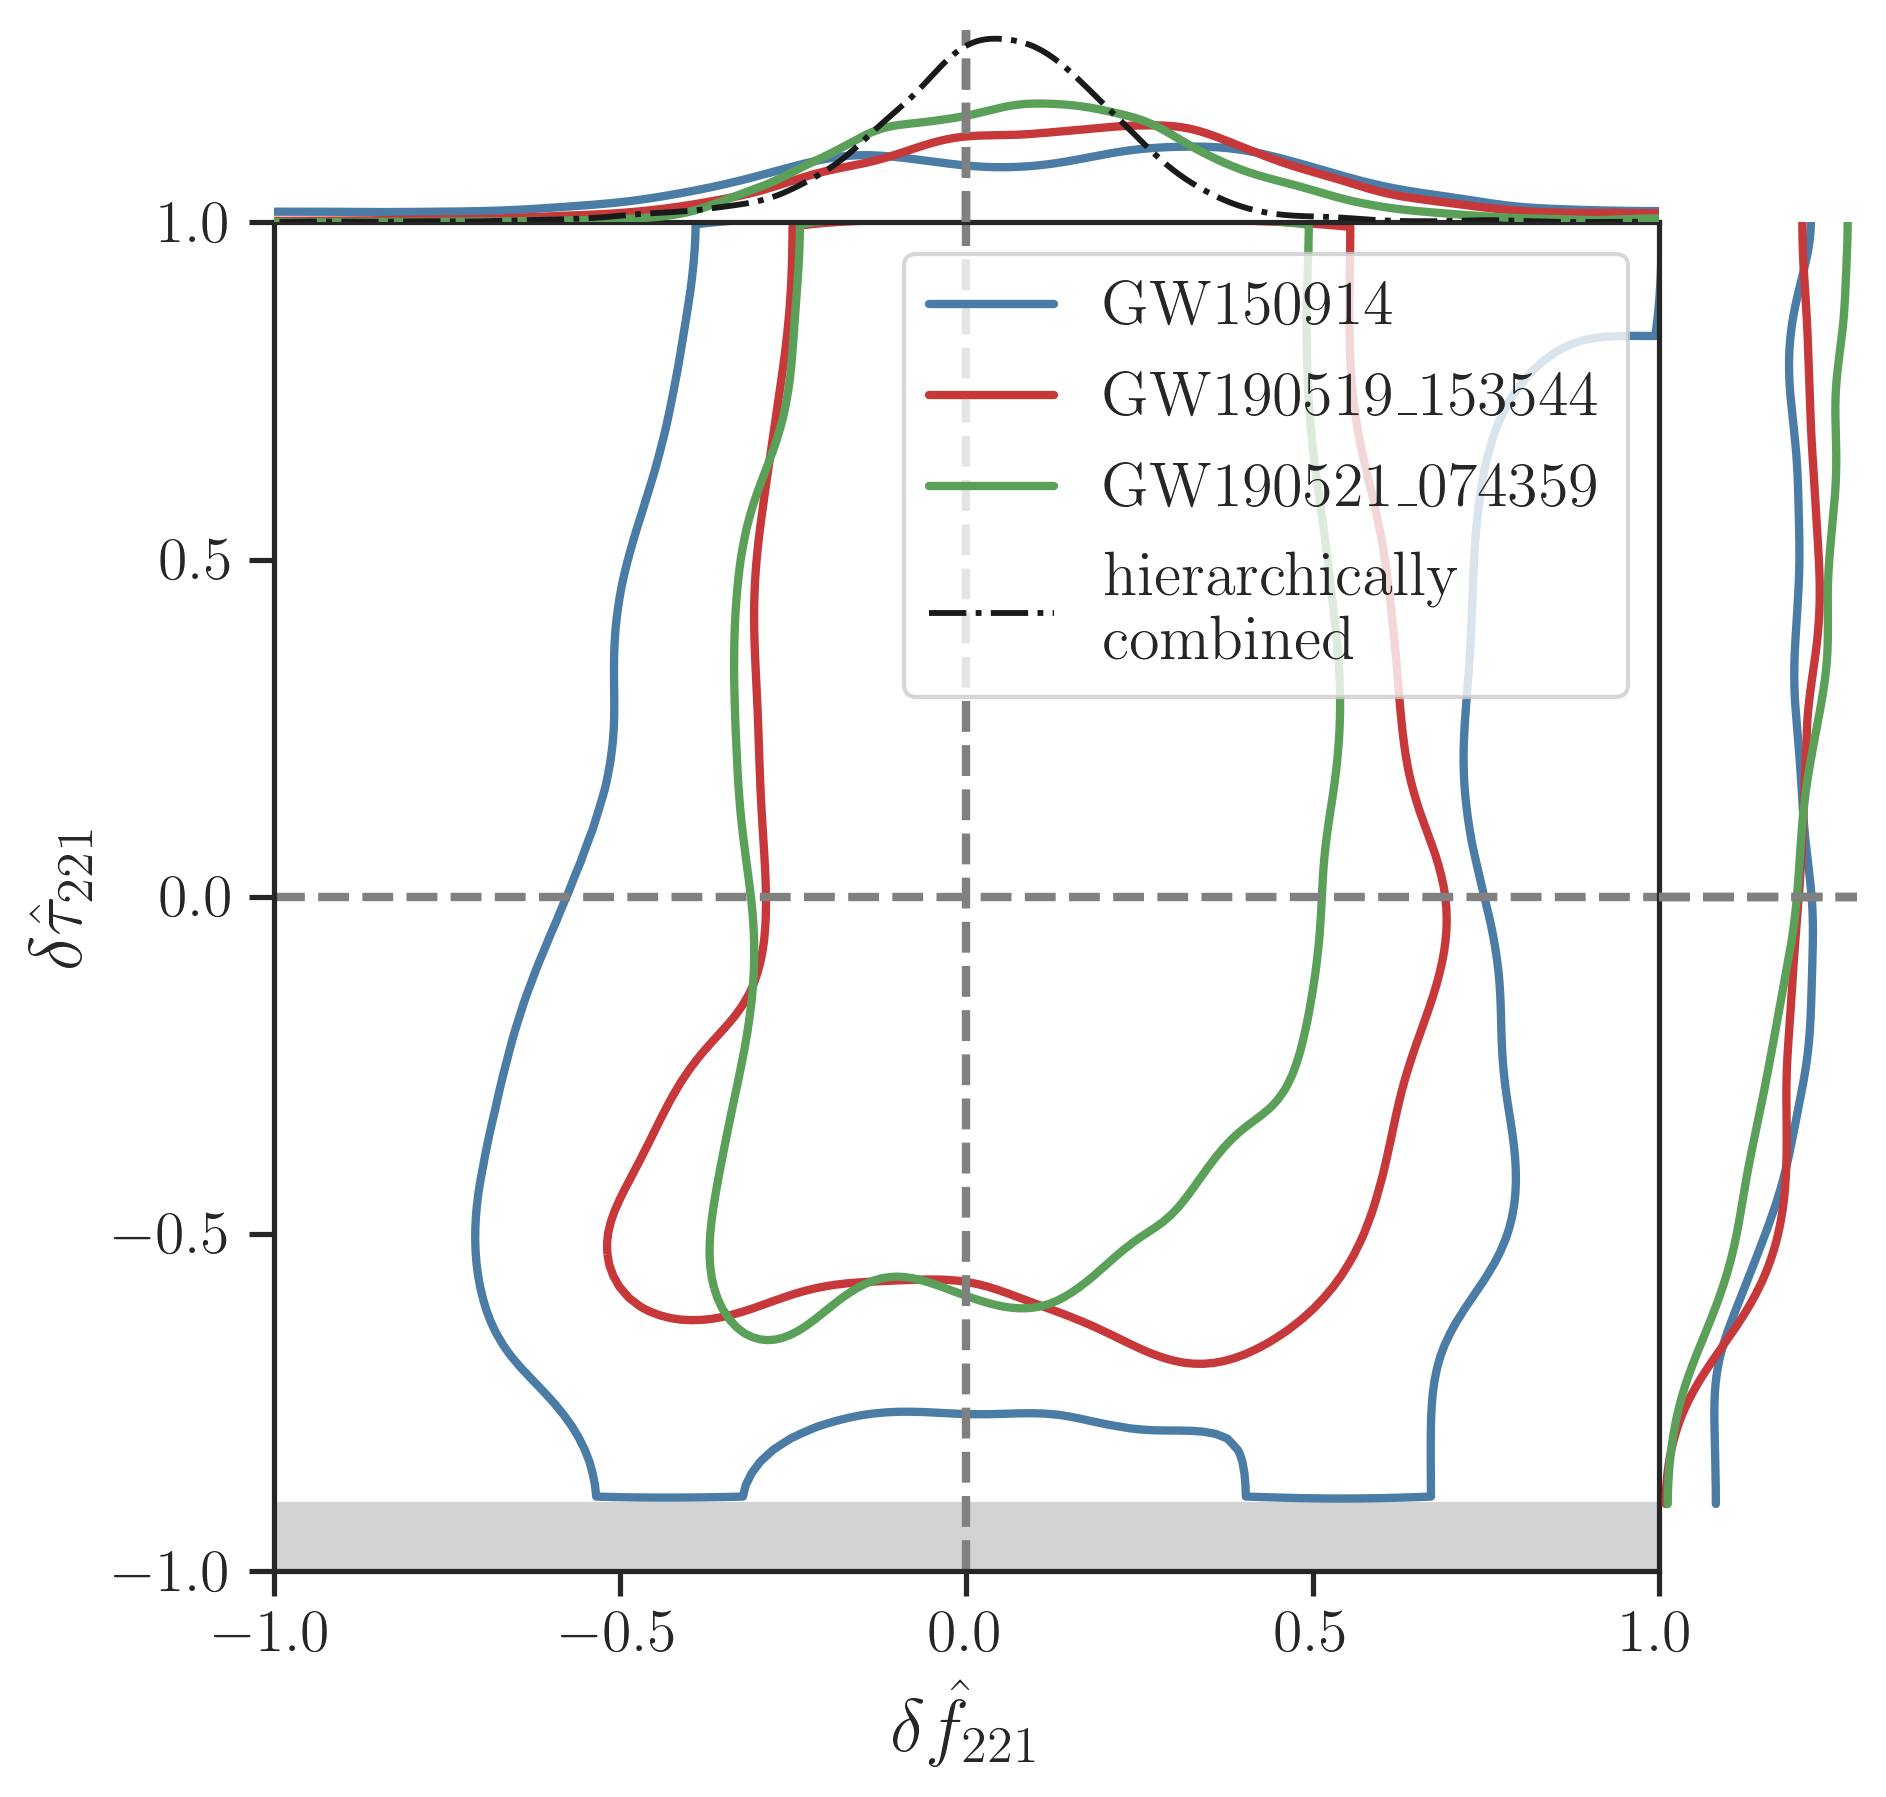

In [3]:
def kde_helper(samples, xlow=None, xhigh=None):
    # Initialize bounded KDE
    if xlow is None:
        xlow = np.amin(samples)
    if xhigh is None:
        xhigh = np.amax(samples)
    kde = Bounded_1d_kde(samples, xlow=xlow, xhigh=xhigh)
    pts = np.linspace(xlow, xhigh, num=500)
    pdf = kde(pts)
    
    return pts, pdf

# Load samples first
sample_dict = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_file_path_template.format(event=event, param=param))

# Tune the min and max params for visualization
df_221_min = -1.
df_221_max = +1.
dtau_221_min = -1.
dtau_221_max = +1.

tick_pos_df_221 = np.linspace(df_221_min, df_221_max, num=5)
tick_pos_dtau_221 = np.linspace(dtau_221_min, dtau_221_max, num=5)

fig = plt.figure(dpi=150, figsize=utils.figsize_square) # Make a square plot
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[7,1], height_ratios=[1,7])
# Tune the plot settings
ax_joint = fig.add_subplot(gs[1,0])
ax_joint.set_xlabel(r"$\delta \hat{f}_{221}$")
ax_joint.set_ylabel(r"$\delta \hat{\tau}_{221}$")
ax_joint.set_xticks(tick_pos_df_221)
ax_joint.set_yticks(tick_pos_dtau_221)

ax_df_221 = fig.add_subplot(gs[0,0], sharex=ax_joint)
plt.setp(ax_df_221.get_xticklabels(), visible=False)
plt.setp(ax_df_221.get_yticklabels(), visible=False)
ax_dtau_221 = fig.add_subplot(gs[1,1], sharey=ax_joint)
plt.setp(ax_dtau_221.get_xticklabels(), visible=False)
plt.setp(ax_dtau_221.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=0.,wspace=0.)

for event in event_list:
    e = utils.Event(event)
    
    color = color_dict[event]
    alpha = 1.0
    name = e.name
    linewidth = 2

    # Plot domega221 first
    pts, pdf = kde_helper(sample_dict["domega_221"][event], xlow=df_221_min, xhigh=df_221_max)
    ax_df_221.plot(pts, pdf, linewidth=linewidth, color=color, label=name, alpha=alpha)
    ax_df_221.axvline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot dtau221 next
    pts, pdf = kde_helper(sample_dict["dtau_221"][event], xlow=-0.9, xhigh=dtau_221_max)
    ax_dtau_221.plot(pdf, pts, linewidth=linewidth, color=color, alpha=alpha)
    ax_dtau_221.axhline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot the joint distribution (with 90% contour) at last using utils.kdeplot_2d_clevels
    # We fix the random seed here for consistency
    np.random.seed(190519)
    # Reduce the number of samples used to train the Gaussian KDE for speed
    choice = np.random.choice(len(sample_dict["domega_221"][event]), size=5000)
    x_train = sample_dict["domega_221"][event][choice]
    y_train = sample_dict["dtau_221"][event][choice]
    utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=df_221_min, xhigh=df_221_max, ylow=-0.9, yhigh=dtau_221_max, ax=ax_joint, linewidths=[linewidth], colors=[color], alpha=alpha)


ax_joint.axvline(0, ls="--", c="grey", linewidth=2)
ax_joint.axhline(0, ls="--", c="grey", linewidth=2)

ax_joint.fill_between(np.arange(df_221_min, df_221_max+1, 1), dtau_221_min, -0.9, color="lightgrey")

# Plot the hierarchical results
# domega_221
df_221_hier_pts, df_221_hier_pdf = kde_helper(np.loadtxt("hierarchical/pyring/{param}_pop.txt.gz".format(param="domega_221")))
ax_df_221.plot(df_221_hier_pts, df_221_hier_pdf, linewidth=0.7*linewidth, c="k", ls="-.", label="hierarchically\ncombined")

ax_joint.set_xlim(df_221_min, df_221_max)
ax_joint.set_ylim(dtau_221_min, dtau_221_max)
ax_df_221.set_ylim(bottom=0.0)
ax_dtau_221.set_xlim(left=0.0)
ax_df_221.axis("off")
ax_dtau_221.axis("off")

ax_joint.legend(*ax_df_221.get_legend_handles_labels(), loc=1, frameon=True, framealpha=0.8, prop={'size': 15})
plt.savefig("rin_pyring_results.pdf", bbox_inches="tight")